In [4]:
# read .csv into python
import pandas as pd
import numpy as np
import os
data = pd.read_csv('D:/Columbia/Fall 2018/PTA/Project/beeradvocate1.csv', sep='^', engine='python', 
                   header=None, error_bad_lines=False)

Skipping line 146: Expected 13 fields in line 146, saw 14
Skipping line 197: Expected 13 fields in line 197, saw 14
Skipping line 5470: Expected 13 fields in line 5470, saw 15
Skipping line 5815: Expected 13 fields in line 5815, saw 14
Skipping line 8842: Expected 13 fields in line 8842, saw 14
Skipping line 11572: Expected 13 fields in line 11572, saw 14
Skipping line 20877: Expected 13 fields in line 20877, saw 14
Skipping line 21294: Expected 13 fields in line 21294, saw 15
Skipping line 23102: Expected 13 fields in line 23102, saw 14
Skipping line 28434: Expected 13 fields in line 28434, saw 14
Skipping line 29729: Expected 13 fields in line 29729, saw 14
Skipping line 30980: Expected 13 fields in line 30980, saw 14
Skipping line 32986: Expected 13 fields in line 32986, saw 15
Skipping line 33672: Expected 13 fields in line 33672, saw 14
Skipping line 33867: Expected 13 fields in line 33867, saw 14
Skipping line 38704: Expected 13 fields in line 38704, saw 14
Skipping line 39392: E

In [5]:
data.columns = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']

# keep 3 columns: user name, beer name, overall score
data2 = data[['beer_name', 'review_profileName', 'review_overall', 'review_time']]
#print(data2.shape)

# remove NA
data2 = data2[pd.notnull(data2.beer_name)]
data2 = data2[pd.notnull(data2.review_profileName)]
data2 = data2[pd.notnull(data2.review_overall)]
print(data2.shape)
#data2.head(10)

(1585696, 4)


In [6]:
# keep top 2000/33382 frequent users
user = data2.review_profileName.value_counts()
user_list = user.keys()[:2000].tolist()

# keep top 200/56855 most reviewed beer
beer = data2.beer_name.value_counts()[:200]
beer_list = beer.keys()[:200].tolist()

# keep (beer&user) pair in (user_list) and (beer_list)
subdata = data2[data2.beer_name.isin(beer_list)]
subdata = subdata[subdata.review_profileName.isin(user_list)]

# sort by user names
subdata = subdata.sort_values(by=['review_profileName','beer_name','review_time'])

print(subdata.shape)


(177151, 4)


In [7]:
#subdata.groupby(['beer_name', 'review_profileName'])['review_time'].max()

data_clean = subdata.sort_values(by='review_time')

data_clean.drop_duplicates(['beer_name', 'review_profileName'], keep = 'last',
                          inplace = True)
data_clean['review_overall'] = data_clean['review_overall'].astype(float)

data_train = data_clean.sample(frac = 0.7, random_state=1)
data_test = data_clean.drop(data_train.index)
#len(list(set(data_train.beer_name)))



<h1> Questions that we will be answering </h1>

- Which Matrix factorisation techniques give a better result for the Beer recomendation system ? NMF or SVD
- How does number of latent factors for matrix factorisation affect the recomendation algorithm ?
- How much does regularisation for users and items affect the recommendation algorithm in Non negetive matrix factorisation algorithm?


In [8]:
from surprise import NMF, GridSearch, Reader, Dataset, SVD
from surprise.model_selection import GridSearchCV

First, let look at the both the Alogrithms 

<h3>0. Data preprocessing </h3>

In [9]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data_clean[['review_profileName', 'beer_name', 'review_overall']], reader)

<h2> Non negative martix factorisation </h2>

Here, we will be running the algorithm by considering various different parameters like number of factors and Regularisation parameters for user and items.  


<h2>Non negative martix facotrisation</h2>

Here, we will be running the algorithm by considering various different parameters like number of factors and Regularisation parameters for user and items.  

<h3>1. Algorithm </h3>

In [75]:
# NMF - Non negative martix facotrisation 
# n_factors – The number of factors. Default is 15.
# n_epochs – The number of iteration of the Stochastic gradient descent procedure.
# reg_pu – The regularization term for users λu.
# reg_qi – The regularization term for items λi.


import time
start_time = time.time()
param_grid = {'n_factors': [15, 20, 25, 30], 'n_epochs': [50], 'reg_pu': [0.01, 0.05, 0.1], 'reg_qi': [0.01, 0.05, 0.1]}
grid_search_nmf = GridSearchCV(NMF, param_grid, measures=['RMSE', 'MAE'], cv = 5)
grid_search_nmf.fit(data)
results_df_nmf = pd.DataFrame.from_dict(grid_search_nmf.cv_results)
results_df_nmf

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi
0,0.581079,0.577239,0.579164,0.578836,0.582870,0.579838,0.001947,16,0.441851,0.437781,...,17,8.350265,0.110396,0.237558,0.032859,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.01,0.01
1,0.574777,0.566774,0.564386,0.573967,0.572127,0.570406,0.004103,12,0.436405,0.430044,...,14,8.196457,0.048164,0.226601,0.028681,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.01,0.05
2,0.566086,0.561652,0.560261,0.564077,0.566147,0.563645,0.002359,9,0.428676,0.424187,...,8,8.391943,0.041362,0.218810,0.039220,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.01,0.10
3,0.572679,0.569210,0.572754,0.573409,0.572723,0.572155,0.001497,13,0.432548,0.431236,...,15,8.106908,0.029368,0.225401,0.031008,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.05,0.01
4,0.565211,0.560687,0.561944,0.565420,0.565635,0.563779,0.002055,10,0.428987,0.425764,...,12,8.095361,0.064869,0.211630,0.038626,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.05,0.05
5,0.561313,0.558202,0.556220,0.559078,0.562034,0.559370,0.002109,6,0.425543,0.424493,...,6,8.165346,0.028708,0.229998,0.034647,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.05,0.10
6,0.566084,0.563721,0.563649,0.565255,0.569616,0.565665,0.002182,11,0.427729,0.426814,...,11,8.123456,0.033996,0.212440,0.040427,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.10,0.01
7,0.561349,0.556601,0.555258,0.562783,0.562292,0.559657,0.003107,7,0.425590,0.423127,...,7,8.239956,0.047441,0.237755,0.025351,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.10,0.05
8,0.561845,0.559681,0.557996,0.561879,0.562505,0.560781,0.001690,8,0.428537,0.428453,...,13,8.218214,0.062902,0.231387,0.031498,"{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0....",15,50,0.10,0.10
9,0.944626,0.925044,0.916812,0.926680,0.921482,0.926929,0.009475,30,0.779397,0.762396,...,30,9.101064,0.089002,0.214831,0.043434,"{'n_factors': 20, 'n_epochs': 50, 'reg_pu': 0....",20,50,0.01,0.01



<h4> For the above algorithm, Here are the least RMSE and MAE values and their correspoding parameters </h4>

In [76]:
# For Root mean square error
print("Least root mean square error")
print(grid_search_nmf.best_score['rmse'])
print("Grid parameters")
print(grid_search_nmf.best_params['rmse'])
print("")
# For mean average error
print("Least mean average error")
print(grid_search_nmf.best_score['mae'])
print("Grid parameters")
print(grid_search_nmf.best_params['mae'])

Least root mean square error
0.5501932876797813
Grid parameters
{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0.1, 'reg_qi': 0.1}

Least mean average error
0.4101820429456712
Grid parameters
{'n_factors': 30, 'n_epochs': 50, 'reg_pu': 0.1, 'reg_qi': 0.1}


<h3>2. Mean errors for different number of latent factors </h3>

To check the accuracy of the NMF algorithm on the number of latent factors, we will set both the regularised parameters to 0.01  

In [175]:
param_grid = {'n_factors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'n_epochs': [50], 'reg_pu': [0.1], 'reg_qi': [0.1]}
grid_search_nmf = GridSearchCV(NMF, param_grid, measures=['RMSE', 'MAE'], cv = 5)
grid_search_nmf.fit(data)
nmf_factors = pd.DataFrame.from_dict(grid_search_nmf.cv_results)


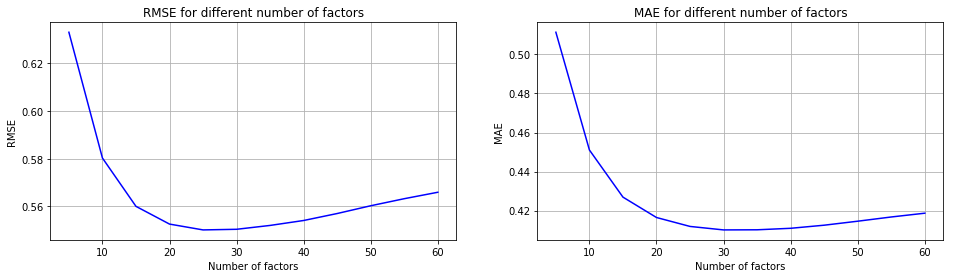

In [176]:
# RMSE and MAE comparisions for number of factors @ regularised parameters = 0.1 for NMF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
ax1.plot(nmf_factors.param_n_factors,nmf_factors.mean_test_rmse, 'b')
ax1.set(xlabel='Number of factors', ylabel='RMSE', title='RMSE for different number of factors for NMF')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(nmf_factors.param_n_factors,nmf_factors.mean_test_mae, 'b')
ax2.set(xlabel='Number of factors', ylabel='MAE', title='MAE for different number of factors for SVD')
ax2.grid()

plt.show()

**RMSE**: As we can see, the RMSE for less number of factors is quite high as at that number, the model is over simplified. As the number of factors increased, the RMSE quickly decreased and reach a minimum at 25 factors. This is optimal number of factors that can be used. After 25 factors, the RMSE started to increase gradually as the model becomes overfit.

**MAE**: Similar to the RMSE, the MAE for the model high for lower number of factors due to the model over simplification, minimised at 30 factors and then gradually increases as overfitting comes into the picture

<h3>3. Comparitive study of Regularisation Terms for NMF for Beer dataset </h3> 

Here we will contrast and compare the effect of regularisation parameters on the recomendation algorithm to determine whether the recommendation is a better one for high regularisation parameter for user or for item. This can tell us whether the scores given by the user are more important or the scores that an item has recieved is more important.

Note that the optimal regularisation term for user and item are 0.1 and 0.1 respectively   

In [131]:
param_grid_pu = {'n_factors': [25], 'n_epochs': [50], 'reg_pu': [0.01, 0.05, 0.1, 0.5, 1.0], 'reg_qi': [0.1]}
grid_search_pu = GridSearchCV(NMF, param_grid_pu, measures=['RMSE', 'MAE'], cv = 5)
grid_search_pu.fit(data)
results_pu = pd.DataFrame.from_dict(grid_search_pu.cv_results)
results_pu

param_grid_qi = {'n_factors': [25], 'n_epochs': [50], 'reg_pu': [0.1], 'reg_qi': [0.01, 0.05, 0.1,  0.5, 1.0]}
grid_search_qi = GridSearchCV(NMF, param_grid_qi, measures=['RMSE', 'MAE'], cv = 5)
grid_search_qi.fit(data)
results_qi = pd.DataFrame.from_dict(grid_search_qi.cv_results)
results_qi

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_reg_pu,param_reg_qi
0,0.798646,0.774222,0.784002,0.794424,0.785154,0.787290,0.008556,4,0.633049,0.609322,...,4,10.371177,0.237802,0.265085,0.083815,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.01
1,0.577041,0.572983,0.571362,0.578629,0.575183,0.575039,0.002633,3,0.427388,0.424823,...,3,10.128770,0.216588,0.274466,0.055564,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.05
2,0.552610,0.549850,0.547585,0.551488,0.549743,0.550255,0.001710,1,0.413821,0.411747,...,1,9.822517,0.193094,0.244146,0.069060,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.10
3,0.555137,0.553974,0.549775,0.555423,0.553711,0.553604,0.002023,2,0.420221,0.419477,...,2,9.797792,0.154309,0.271268,0.056883,"{'n_factors': 25, 'n_epochs': 50, 'reg_pu': 0....",25,50,0.1,0.15


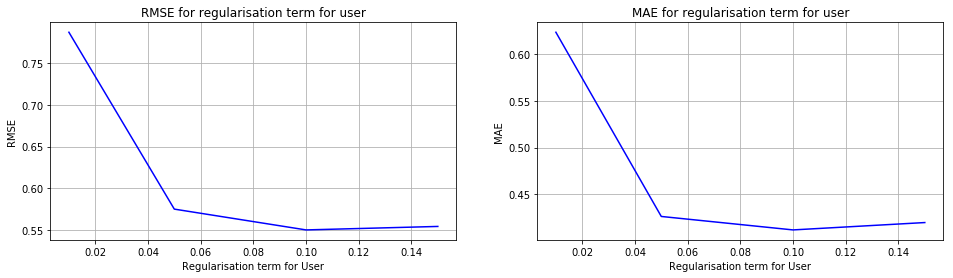

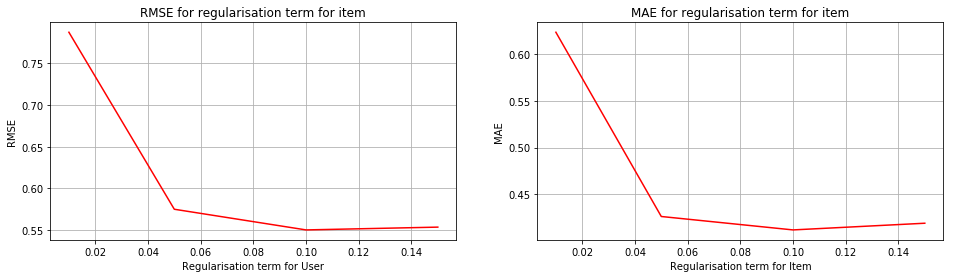

In [151]:
# RMSE and MAE comparisions for Regularisation parameters
fig = plt.figure(figsize=(16,4))

# RMSE and MAE comparisions for number of factors @ regularised parameters = 0.1 for NMF

ax1 = fig.add_subplot(121)
ax1.plot(results_pu.param_reg_pu, results_pu.mean_test_rmse, 'b')
ax1.set(xlabel='Regularisation term for User', ylabel='RMSE', title='RMSE for regularisation term for user')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(results_pu.param_reg_pu, results_pu.mean_test_mae, 'b')
ax2.set(xlabel='Regularisation term for User', ylabel='MAE', title='MAE for regularisation term for user')
ax2.grid()

fig2 = plt.figure(figsize=(16,4))

# RMSE and MAE comparisions for number of factors @ regularised parameters = 0.1 for NMF

ax3 = fig2.add_subplot(121)
ax3.plot(results_qi.param_reg_qi, results_qi.mean_test_rmse, 'r')
ax3.set(xlabel='Regularisation term for Item', ylabel='RMSE', title='RMSE for regularisation term for Item')
ax3.grid()

ax4 = fig2.add_subplot(122)
ax4.plot(results_qi.param_reg_qi, results_qi.mean_test_mae, 'r')
ax4.set(xlabel='Regularisation term for Item', ylabel='MAE', title='MAE for regularisation term for Item')
ax4.grid()

plt.show()


The above plot shows that for both items and users, the optimal regularisation terms are 0.1. It also shows that for regularisation terms less than 0.1, the RMSE and MAE increase is exponential compared to the the regularisation terms being more than 0.1. 


<h2>Singular value decomposition</h2>

Here, we will be running the algorithm by considering various different parameters like number of factors and Regularisation parameter and learning rate .

<h4>1. Algorithm</h4>

In [173]:
# SVD - Singular Value Decomposition
# n_factors – The number of factors. Default is 100.
# n_epochs – The number of iteration of the SGD procedure. Default is 20.
# lr_all – The learning rate for all parameters. Default is 0.005.
# reg_all – The regularization term for all parameters. Default is 0.02.



param_grid = {'n_factors': [15, 20, 25, 30], 'n_epochs': [50], 'lr_all': [0.01, 0.05, 0.1], 'reg_all': [0.01, 0.05, 0.1]}
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search_svd.fit(data)
results_svd = pd.DataFrame.from_dict(grid_search_svd.cv_results)
results_svd

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
0,0.583472,0.579453,0.580362,0.579784,0.583545,0.581323,0.001808,25,0.432246,0.430637,...,25,8.081286,0.527456,0.288933,0.070941,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.01,0.01
1,0.540569,0.535420,0.540396,0.537950,0.539836,0.538834,0.001944,3,0.401239,0.399077,...,3,8.267413,0.099963,0.331709,0.058226,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.01,0.05
2,0.546354,0.541469,0.546078,0.543894,0.546908,0.544941,0.002016,8,0.406650,0.404063,...,8,8.031560,0.083505,0.287519,0.068223,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.01,0.10
3,0.617124,0.613615,0.612313,0.613157,0.614587,0.614159,0.001654,29,0.455308,0.455207,...,29,8.173079,0.393308,0.315518,0.072552,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.05,0.01
4,0.555831,0.549006,0.553925,0.551191,0.552463,0.552483,0.002326,13,0.413327,0.410852,...,9,7.914287,0.081066,0.282673,0.070632,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.05,0.05
5,0.554714,0.549452,0.553649,0.550355,0.552893,0.552213,0.001993,12,0.413610,0.411431,...,16,7.802744,0.062522,0.311171,0.060126,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.05,0.10
6,0.640041,0.633003,0.638159,0.635374,0.635610,0.636437,0.002431,31,0.476060,0.472643,...,31,8.193561,0.077068,0.299242,0.074415,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.10,0.01
7,0.570639,0.565208,0.569234,0.566440,0.566282,0.567561,0.002035,23,0.426383,0.424508,...,22,8.339455,0.314492,0.333642,0.059669,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.10,0.05
8,0.568740,0.562944,0.567300,0.563868,0.565530,0.565677,0.002134,20,0.425859,0.423206,...,20,8.283587,0.108963,0.334886,0.065681,"{'n_factors': 15, 'n_epochs': 50, 'lr_all': 0....",15,50,0.10,0.10
9,0.591253,0.590877,0.588238,0.589048,0.593251,0.590533,0.001760,26,0.438117,0.438635,...,26,8.802151,0.559393,0.281435,0.074038,"{'n_factors': 20, 'n_epochs': 50, 'lr_all': 0....",20,50,0.01,0.01


In [174]:
# For Root mean square error
print("Least root mean square error")
print(grid_search_svd.best_score['rmse'])
print("Grid parameters")
print(grid_search_svd.best_params['rmse'])
print("")
# For mean average error
print("Least mean average error")
print(grid_search_svd.best_score['mae'])
print("Grid parameters")
print(grid_search_svd.best_params['mae'])

Least root mean square error
0.5387486953182344
Grid parameters
{'n_factors': 30, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.05}

Least mean average error
0.4016786450419912
Grid parameters
{'n_factors': 30, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.05}


<h3>2. Errors for different number of latent factors in SVD</h3>

To check the accuracy of SVD algorithm for different varying factor. The learning rate had been kept at 0.01 and the regularisation rate has been kept at 0.05

In [172]:
param_grid = {'n_factors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'n_epochs': [50], 'lr_all': [0.01], 'reg_all': [0.05]}
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv = 5)
grid_search_svd.fit(data)
svd_factors = pd.DataFrame.from_dict(grid_search_svd.cv_results)

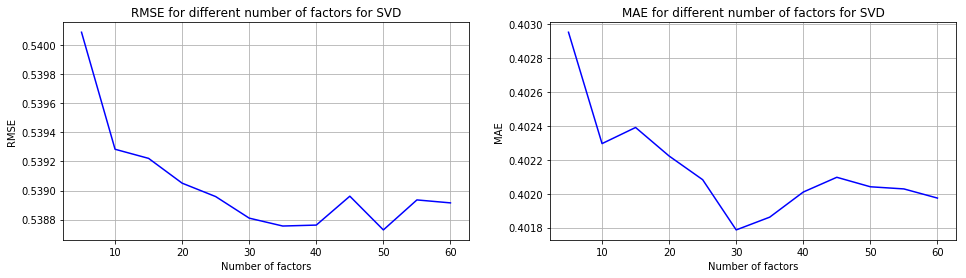

In [170]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
ax1.plot(svd_factors.param_n_factors,svd_factors.mean_test_rmse, 'b')
ax1.set(xlabel='Number of factors', ylabel='RMSE', title='RMSE for different number of factors for SVD')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(svd_factors.param_n_factors,svd_factors.mean_test_mae, 'b')
ax2.set(xlabel='Number of factors', ylabel='MAE', title='MAE for different number of factors for SVD')
ax2.grid()

plt.show()

The RMSE for SVD seems to be less for number of factors 30, 35, 40 and 50 and MAE is less when number of factors are 30. Hence the optimal number of factors to be taken for SVD is 30


<h2>Comparision of NMF and SVD algorithms </h2>

Let us see how the 2 algorithms contrast with each other with varying factors

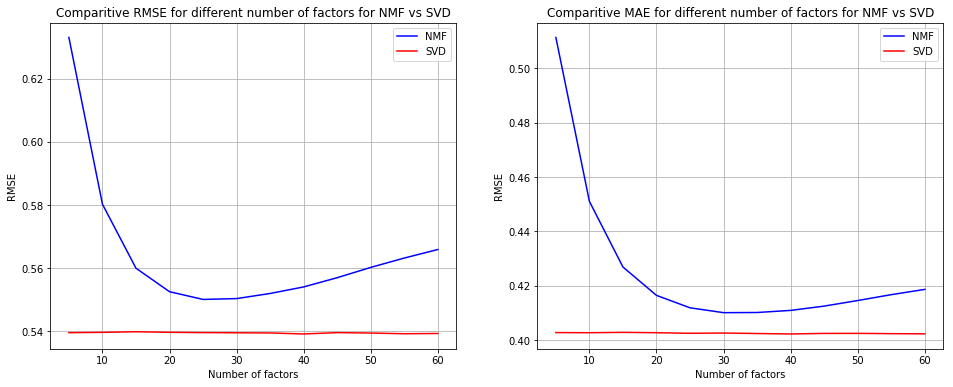

In [208]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
ax1.plot(nmf_factors.param_n_factors, nmf_factors.mean_test_rmse, 'b', 
         svd_factors.param_n_factors,svd_factors.mean_test_rmse, 'r')
ax1.set(xlabel='Number of factors', ylabel='RMSE', title='Comparitive RMSE for different number of factors for NMF vs SVD')
ax1.grid()
ax1.legend(['NMF',"SVD"])

ax2 = fig.add_subplot(122)
ax2.plot(nmf_factors.param_n_factors, nmf_factors.mean_test_mae, 'b',  
         svd_factors.param_n_factors, svd_factors.mean_test_mae, 'r')
ax2.set(xlabel='Number of factors', ylabel='RMSE', title='Comparitive MAE for different number of factors for NMF vs SVD')
ax2.grid()
ax2.legend(['NMF',"SVD"])


plt.show()

This shows that the SVD is a better algorithm than NMF for the beer dataset.
<h2>Top ten recommendation</h2>
Given a user, Give the top ten recommended Beers for that user. 
Looking at the results given above, we will use the SVD algorithm

In [43]:
from collections import defaultdict

training_set = data.build_full_trainset()
algo = SVD(n_factors = 30, lr_all = 0.01, reg_all = 0.05)
algo.fit(training_set)
unfilled = training_set.build_anti_testset()
recommendation = algo.test(unfilled)
top_10 = recommend_10(algo.test(unfilled))

top_10 = defaultdict(list)
for uid, iid, u_id, est, details in recommendation:
    top_10[uid].append((iid, est))
for uid, user_ratings in top_10.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_10[uid] = user_ratings[:10]

for uid, user_ratings in top_10.items():
    print(uid, [iid for (iid, details) in user_ratings])




 Jason [' Founders KBS (Kentucky Breakfast Stout)', ' The Abyss', ' Founders Breakfast Stout', ' TrÃ¶egs Nugget Nectar', " Bell's Hopslam Ale", ' Furious', ' Blind Pig IPA', ' Sculpin India Pale Ale', ' AleSmith Speedway Stout', ' Founders Imperial Stout']
 AaronRed [' Trappist Westvleteren 12', ' Pliny The Elder', ' Founders KBS (Kentucky Breakfast Stout)', ' The Abyss', ' Founders Breakfast Stout', ' TrÃ¶egs Nugget Nectar', ' Supplication', " Bell's Hopslam Ale", ' Gumballhead', ' Furious']
 guinness33 [' Pliny The Elder', ' Founders KBS (Kentucky Breakfast Stout)', ' The Abyss', ' Supplication', " Bell's Hopslam Ale", ' La Fin Du Monde', ' Furious', ' Sculpin India Pale Ale', ' Great Lakes Edmund Fitzgerald Porter', ' Schneider Aventinus']
 Tim [' Trappist Westvleteren 12', ' Pliny The Elder', ' Founders KBS (Kentucky Breakfast Stout)', ' Weihenstephaner Hefeweissbier', ' Founders Breakfast Stout', ' The Abyss', ' Supplication', ' TrÃ¶egs Nugget Nectar', " Bell's Hopslam Ale", ' Gum

 cyrenaica [' Trappist Westvleteren 12', ' Founders KBS (Kentucky Breakfast Stout)', ' Pliny The Elder', ' The Abyss', ' Founders Breakfast Stout', ' Supplication', " Bell's Hopslam Ale", ' Bourbon County Brand Stout', ' TrÃ¶egs Nugget Nectar', ' Stone Imperial Russian Stout']
 Halcyondays [' Trappist Westvleteren 12', ' TrÃ¶egs Nugget Nectar', ' Furious', ' Founders Imperial Stout', ' Founders Double Trouble', ' Smuttynose IPA "Finest Kind"', ' Founders Centennial IPA', ' TrÃ¶egs Hopback Amber Ale', ' Brooklyn Black Chocolate Stout', " Bell's Special Double Cream Stout"]
 t0rin0 [' Trappist Westvleteren 12', ' Pliny The Elder', ' Weihenstephaner Hefeweissbier', ' Founders KBS (Kentucky Breakfast Stout)', ' Founders Breakfast Stout', ' TrÃ¶egs Nugget Nectar', ' Supplication', ' Gumballhead', ' Duvel', ' Furious']
 berserker256 [' Trappist Westvleteren 12', ' Pliny The Elder', ' Gumballhead', ' Supplication', ' TrÃ¶egs Nugget Nectar', ' Founders Breakfast Stout', ' The Abyss', ' Sculpin

 TheSevenDuffs [' Supplication', ' Blind Pig IPA', ' Schneider Aventinus', ' Trappistes Rochefort 10', ' Allagash White', ' Chimay Grande RÃ©serve (Blue)', " Fuller's London Porter", ' Northern Hemisphere Harvest Wet Hop Ale', ' Westmalle Trappist Tripel', " Samuel Smith's, The Famous Taddy Porter"]
 speter [' Trappist Westvleteren 12', ' Pliny The Elder', ' Founders KBS (Kentucky Breakfast Stout)', ' The Abyss', ' Founders Breakfast Stout', ' Supplication', ' TrÃ¶egs Nugget Nectar', " Bell's Hopslam Ale", ' Dreadnaught IPA', ' Furious']
 djbreezy [' Founders Breakfast Stout', ' TrÃ¶egs Nugget Nectar', ' Gumballhead', ' Furious', ' Schneider Aventinus', ' Black Butte Porter', ' Great Lakes Edmund Fitzgerald Porter', ' Two Hearted Ale', ' Alpha King Pale Ale', ' Founders Imperial Stout']
 hopsbreath [' Trappist Westvleteren 12', ' Founders KBS (Kentucky Breakfast Stout)', ' Weihenstephaner Hefeweissbier', ' TrÃ¶egs Nugget Nectar', ' Blind Pig IPA', ' Great Lakes Edmund Fitzgerald Porter

In [50]:
#To Predict for given user
def predict_for_user(user):
    for uid, user_ratings in top_10.items():
        if (str(uid) == str(user)):
            print(uid, [iid for (iid, details) in user_ratings])

In [52]:
predict_for_user(" Jason")


 Jason [' Founders KBS (Kentucky Breakfast Stout)', ' The Abyss', ' Founders Breakfast Stout', ' TrÃ¶egs Nugget Nectar', " Bell's Hopslam Ale", ' Furious', ' Blind Pig IPA', ' Sculpin India Pale Ale', ' AleSmith Speedway Stout', ' Founders Imperial Stout']
